# 1. Trabajo Práctico N°2: de Analisis + Curación

# Trabajo Práctico N°2: Análisis Exploratorio y Curación de Datos

## Introducción

Este trabajo práctico intenta continúa la exploración de los datasets planteados en el [primer trabajo práctico](https://github.com/luisdvlpr/diplodatos2021-datasets/blob/main/TP1_Analisis_y_Visualizacion/enunciado_tp1_analisis_y_visualizacion.ipynb)

En el primer práctico pudimos notar algunas características propias de las series temporales y en particular del dominio del comportamiento de un ecommerce genérico. Muchas de ellas son __series no estacionarias__, ya que la caracterización de estas distribuciones ( media, varianza ) cambian a través del tiempo y se observan ademas alguna tendencias. __Por otra parte se se distinguen patrones de estacionalidad, por ej. semanal__. 

Lo anterior trae __consecuencias__ directas en la selección de las metodologías adecuadas para abordar las problemáticas de tratamiento de __valores faltantes__, detección de __outliers__ y la construcción de __modelos predictivos__.

Por otra parte, debe notarse que el tamaño de las economías de cada pais y la adopción de los hábitos de uso de estas plataformas en cada uno de ellos hace que el uso de cantidad de sesiones no sea una medida adecuada para compararles. Entonces, el análisis de estas series se centra por lo general en el cambio porcentual de los precios en vez del cambio en los valores absolutos. Esto resulta en que en vez de modelar los índices originales, previamente se habitúa realizar una __transformación logarítmica__ o trabajar con la __tasa de conversión__ a fin de expresarlos en un __único métrica que les caracterice__ para evitar distorsiones debidas a los tamaños de sus economías y hábitos de uso.

### Carga del dataset

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
 
%matplotlib inline
import matplotlib.pyplot as plt

In [35]:
# some config

plt.rcParams['figure.figsize'] = (12, 9)
pd.options.display.float_format = '{:20,.2f}'.format #configuración para sacar la notación cientifica

In [36]:
#cambie parse_dates=True, por la columna especifica de fecha para que aplique el tipo de formato e indexe por fecha
data_orig = pd.read_csv(
    'https://raw.githubusercontent.com/luisepifanio/diplodatos2021-datasets/main/TP2_Analisis_y_Curacion/datasets/traffic_AR_CL_UY.csv', 
    usecols = ["Fecha", "flow", "Site", "Device", "Loading", "Shipping", "Payments", "Review", "Congrats"], 
    parse_dates=["Fecha"],index_col=["Fecha"]
)
traffic_data=data_orig.copy()

In [37]:
#filtramos los datos para trabajar solo con MLA, flujo directo, desktop y android

traffic_data = traffic_data[traffic_data.Site==("MLA")]
traffic_data = traffic_data[traffic_data.flow==("direct")]
traffic_data = traffic_data[(traffic_data.Device==("Android"))|(traffic_data.Device==("Desktop"))]


In [38]:
#agregamos columnas relativas a las fechas

df_traffic=traffic_data.copy()
df_traffic["Weekday"] = traffic_data.index.day_name()
df_traffic["Month"] = traffic_data.index.month_name()
df_traffic["Year"] = traffic_data.index.year
new = df_traffic["Month"].copy().astype(str)
new1 = df_traffic["Year"].copy().astype(str)
df_traffic["Months"]= new.str.cat(new1, sep ="-")

In [39]:
#agregamos columnas relativas a las tasas de conversión entre las diferentes etapas de compra
df_traffic["Shipping-Payments"] = df_traffic["Payments"] / df_traffic["Shipping"]
df_traffic["Payments-Review"] = df_traffic["Review"] / df_traffic["Payments"]
df_traffic["Review-Congrats"] = df_traffic["Congrats"] / df_traffic["Review"]
df_traffic["Shipping-Congrats"] = df_traffic["Congrats"] / df_traffic["Shipping"]

#agrupamos las columnas según sean etapas de compra o índices para evaluar su comportamiento por separado
cols_indices = ['Shipping-Payments', 'Payments-Review', 'Review-Congrats', 'Shipping-Congrats']
cols_etapas = ['Shipping', 'Payments', 'Review', 'Congrats']

# volvemos a definir los dos datasets de interes con las nuevas columnas
df_traffic_desktop = df_traffic[df_traffic.Device==("Desktop")]
df_traffic_android = df_traffic[df_traffic.Device==("Android")]

# Consignas del trabajo práctico N°2

El objetivo general del práctico es realizar algunas tareas de __preprocesamiento__ de los datos y luego __analizar las series obtenidas__ de dicho preprocesamiento en forma similar a la empleada en el TP1.

Se proponen las siguientes actividades orientadoras, sin perjuicio de que se puedan incorporar análisis adicionales:

#### Tratamiento de faltantes

- Identificar valores perdidos, huecos en los datos ej: aquellos días para los que no hubo datos

- Identificar aquellos valores "sospechosos", debido al dropout ( o perdida de sesiones) a medidas que avanzas en 
  las pantallas la cantidad de sesiones en la pantalla posterior es menor/igual al de su predecesora

- Imputar los valores sospechoso con otros que tengan sentido dentro del dominio segun lo explicado en el punto anterior

- Imputar los faltantes debidos a fallas de medición usando un algoritmo adecuado para series temporales, 
  por ejemplo splines, interpolaciones, valores de medias/medianas móviles por ventana de tiempo

- Comparar los valores originales vs los imputados y juzgue si los valores se mantienen dentro de parametros aceptables, ¿Como justificaría que dichos valores imputados tienen sentido en su analisis?


#### Transformaciones

Obtener las siguientes series transformadas:

- Los logaritmos naturales de los índices. 

- Las tasas de conversion.

#### Exploración de las series transformadas

Reutilizar parte del código del TP1 para analizar las series transformadas. En una primera etapa se puede trabajar con solo una de las series resultantes de tomar logaritmo natural y una serie de tasa de conversión.

- Analizar las distribuciones por medio de gráficos y medidas de estadística descriptiva.

- Dichas distribuciones, ¿se mantienen relativamente inalteradas en el tiempo?

- ¿Hay outliers?

- Estudiar la evolución temporal de las series. ¿En qué sentido tienden a moverse? ¿Tienden a moverse en forma conjunta?  ¿Siempre se da dicho patrón? ¿Hay períodos de crisis? En caso de que existan crisis / eventos , ¿Son globales o propias de sites individuales? 

- To Be defined: De ser definido, podemos establecer un grupo de control versus ls valores imputados y establecer 
  que tan buenos resultaron los métodos ejecutados para rellenar los valores respecto de los deseables

#### Opcional
- Graficar e interpretar las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF).
- Explorar la volatilidad de las series, por ejemplo graficando las desviaciones estándar móviles.

## Fecha de entrega

- __Versión preliminar: 03/07__ 

- __Version final: 07/07__

## Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis realizado. El mismo puede orientarse para un público técnico pero que desconoce los aspectos propios del problema como sus compañeros de clase. Dicho informe puede ser un notebook, a condición de que en el mismo se explique un análisis escrito suficientemente detallado de los resultados. 


***DATOS FALTANTES***

In [43]:
#buscamos si hay datos faltantes
df_traffic.isnull().sum()

flow                 0
Site                 0
Device               0
Loading              0
Shipping             1
Payments             0
Review               2
Congrats             0
Weekday              0
Month                0
Year                 0
Months               0
Shipping-Payments    5
Payments-Review      6
Review-Congrats      6
Shipping-Congrats    5
dtype: int64

Solo tres datos aparecen como no valores en el dataset, dos de ellos el la etapa de review y uno en la etapa de shipping. De las columnas agregadas, varias muestran datos faltantes.

In [46]:
#fechas con datos faltantes en el dataset original
df_traffic[df_traffic['Shipping'].isnull()|df_traffic['Review'].isnull()]

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-03-22,direct,MLA,Android,179146,"169,846.00",138177,NaN,89890,Friday,March,2019,March-2019,0.81,NaN,NaN,0.53
2019-05-07,direct,MLA,Android,224056,NaN,172472,"121,321.00",113250,Tuesday,May,2019,May-2019,NaN,0.70,0.93,NaN
2019-08-27,direct,MLA,Android,236701,"223,993.00",180928,NaN,113464,Tuesday,August,2019,August-2019,0.81,NaN,NaN,0.51


In [58]:
#fechas con Nan en las columnas de indice.
missing = df_traffic[pd.isnull(df_traffic).any(axis=1)]
missing

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-03-22,direct,MLA,Android,179146,"169,846.00",138177,NaN,89890,Friday,March,2019,March-2019,0.81,NaN,NaN,0.53
2019-05-07,direct,MLA,Android,224056,NaN,172472,"121,321.00",113250,Tuesday,May,2019,May-2019,NaN,0.70,0.93,NaN
2019-08-27,direct,MLA,Android,236701,"223,993.00",180928,NaN,113464,Tuesday,August,2019,August-2019,0.81,NaN,NaN,0.51
2019-12-05,direct,MLA,Android,0,0.00,0,0.00,0,Thursday,December,2019,December-2019,NaN,NaN,NaN,NaN
2019-12-05,direct,MLA,Desktop,0,0.00,0,0.00,0,Thursday,December,2019,December-2019,NaN,NaN,NaN,NaN
2019-12-06,direct,MLA,Android,0,0.00,0,0.00,0,Friday,December,2019,December-2019,NaN,NaN,NaN,NaN
2019-12-06,direct,MLA,Desktop,0,0.00,0,0.00,0,Friday,December,2019,December-2019,NaN,NaN,NaN,NaN


El dataset presenta valores nulos tanto en las columnas originales como en las columnas indice, especialmente para aquellos casos donde el indice debía usar un input Nan, o bien donde se generaba una división en 0 por falta de datos. 

In [60]:
#buscamos si hay datos faltantes.. se puede buscar con .isna() o con .isnull()
missing.drop('Device', 1).isna().groupby(missing.Device, sort=False).sum()

,flow,Site,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Device,,,,,,,,,,,,,,,
Android,0,0,0,1,0,2,0,0,0,0,0,3,4,4,3
Desktop,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2


Podemos identificar que los 3 datos faltantes corresponden a los devices Android, mientras que Desktop solo presenta Nans en las columnas indice para los dos días que están sin dato: 5 y 6 de diciembre de 2019.

***DATOS NULOS***

In [67]:
#buscamos los datos nulos e identificamos en qué columnas se encuentran..
cols_null_D = df_traffic[df_traffic == 0].count(axis=0)
cols_null_D[cols_null_D > 0]

Loading     4
Shipping    4
Payments    4
Review      4
Congrats    4
dtype: int64

In [86]:
#Buscamos otras filas con valor 0
columns = df_traffic.columns.tolist()
columns
df_traffic_zero = df_traffic[(df_traffic.iloc[:,:] == 0).any(axis=1)]
df_traffic_zero

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,
2019-12-05,direct,MLA,Android,0,0.00,0,0.00,0,Thursday,December,2019,December-2019,NaN,NaN,NaN,NaN
2019-12-05,direct,MLA,Desktop,0,0.00,0,0.00,0,Thursday,December,2019,December-2019,NaN,NaN,NaN,NaN
2019-12-06,direct,MLA,Android,0,0.00,0,0.00,0,Friday,December,2019,December-2019,NaN,NaN,NaN,NaN
2019-12-06,direct,MLA,Desktop,0,0.00,0,0.00,0,Friday,December,2019,December-2019,NaN,NaN,NaN,NaN


Luego de extender la búsqueda podemos afirmar que solo hay dos fechas con valores iguales a 0. En ambos casos, todas las etapas son 0, por ello los convertiremos en Nan y luego los imputaremos.

In [87]:
df_traffic = df_traffic.replace(['0', 0], np.nan)

In [98]:
#Buscamos en el dataset observaciones que no cumplan con la lógica del funnel, que presenten en una etapa previa menos
#observaciones que en una posterior
columns = df_traffic.columns.tolist()
columns
df_traffic_sospechoso = df_traffic[(df_traffic[cols_indices].iloc[:,:] > 1).any(axis=1)]
df_traffic_sospechoso

,flow,Site,Device,Loading,Shipping,Payments,Review,Congrats,Weekday,Month,Year,Months,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
Fecha,,,,,,,,,,,,,,,,


Como el dataset no cuenta con observaciones donde la tasa de conversión entre dos etapas consecutivas sea mayor que 1, concluimos que el dataset no presenta valores sospechosos en este sentido.

In [99]:
# volvemos a definir los dos datasets con los valores correspondientes seteados a nan
df_traffic_desktop = df_traffic[df_traffic.Device==("Desktop")]
df_traffic_android = df_traffic[df_traffic.Device==("Android")]

# Exploración del dataset

Habiendo realizado un primer análisis de valores perdidos y nulos, procedemos a visualizar el dataset buscando otras inconsistencias que deban ser tenidas en cuenta.
En primer lugar observamos los diagramas de caja de las distintas etapas para los dos dispositivos, desktop y android, y luego las tasas de conversión entre etapas de los mismos.

Text(0.5, 1.0, 'Etapas-DESKTOP')

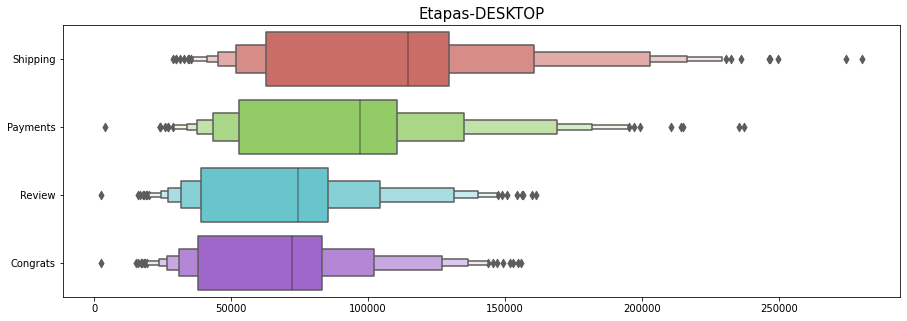

In [104]:
#df_traffic_desktop[cols_etapas].plot( marker='.', alpha=0.5, linestyle='-', figsize=(20, 10)).set_title("DESKTOP")
plt.rcParams['figure.figsize'] = (15, 5)
sns.boxenplot(data=df_traffic_desktop[cols_etapas], orient="h", palette='hls')
plt.title('Etapas-DESKTOP', size=15)


Text(0.5, 1.0, 'Etapas-ANDROID')

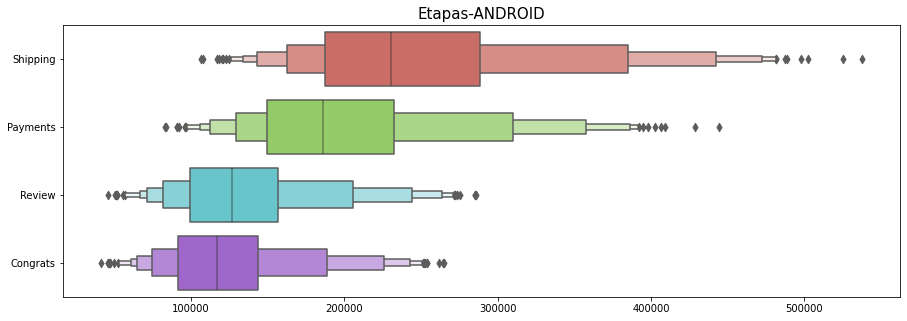

In [105]:
sns.boxenplot(data=df_traffic_android[cols_etapas], orient="h", palette='hls')
plt.title('Etapas-ANDROID', size=15)


 En lineas generales el análisis de los diagramas de caja se mantiene inalterado respecto a lo presentado en la entrega anterior. La distribución de las etapas sigue la lógica de drop-out, como era de esperar, y presenta outliers positivos y negativos en todas las etapas. Llaman la atención los outliers negativos cercanos a cero que se pueden observar especialmente en Android, en las últimas tres etapas.

Text(0.5, 1.0, 'Indices-DESKTOP')

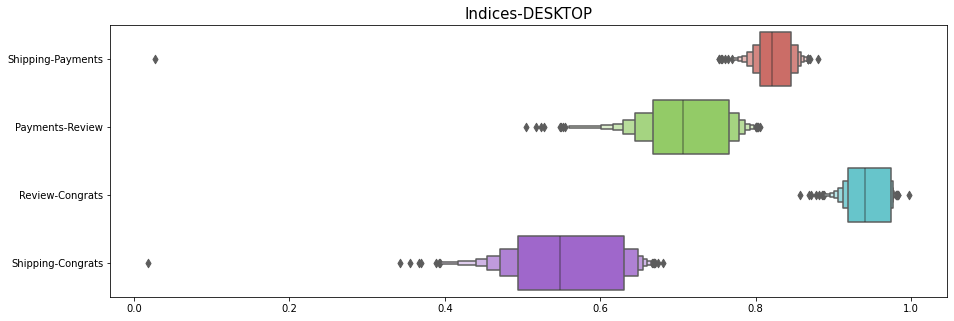

In [108]:
sns.boxenplot(data=df_traffic[cols_indices], orient="h", palette='hls')
plt.title('Indices-DESKTOP', size=15)

Text(0.5, 1.0, 'Indices-ANDROID')

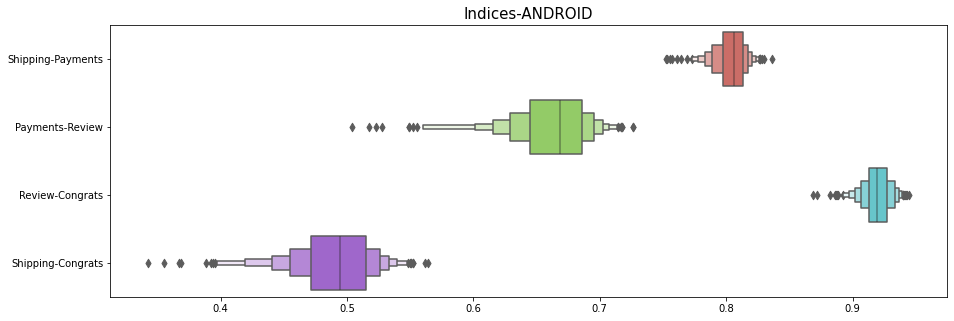

In [109]:
sns.boxenplot(data=df_traffic_android[cols_indices], orient="h", palette='hls')
plt.title('Indices-ANDROID', size=15)

Al analizar las tasas de conversión vemos que aún se mantienem algunos indices cercanos a cero, pero esto sucede porque aún no se han imputado los valores faltantes.

Por último, en esta etapa de visualización se presentan las series temporales de las distintas etapas, divididas por dispositivo, y presentando tanto el dato original como la tasa de conversión.

Text(0.5, 1.0, 'DESKTOP-Indices')

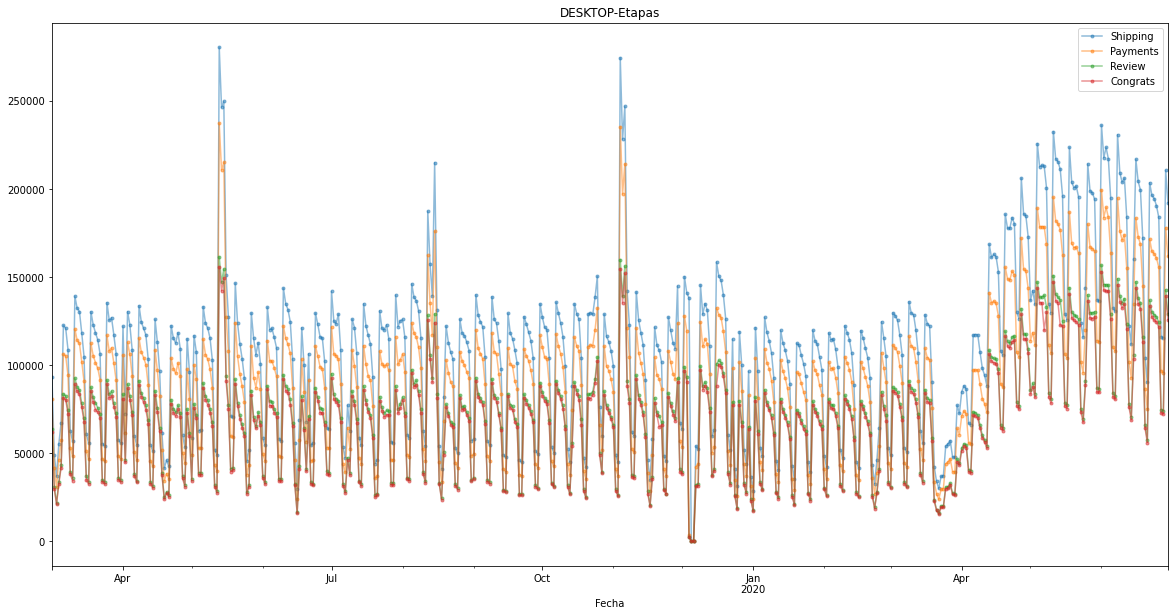

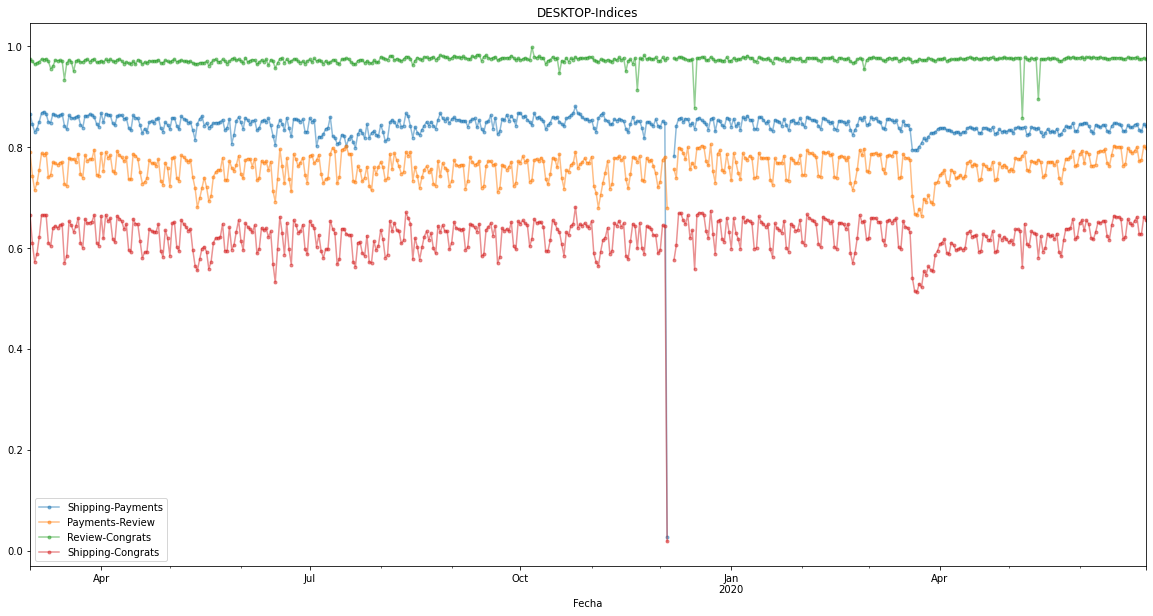

In [93]:
df_traffic_desktop[cols_etapas].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("DESKTOP-Etapas")
df_traffic_desktop[cols_indices].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("DESKTOP-Indices")

Text(0.5, 1.0, 'ANDROID-Indices')

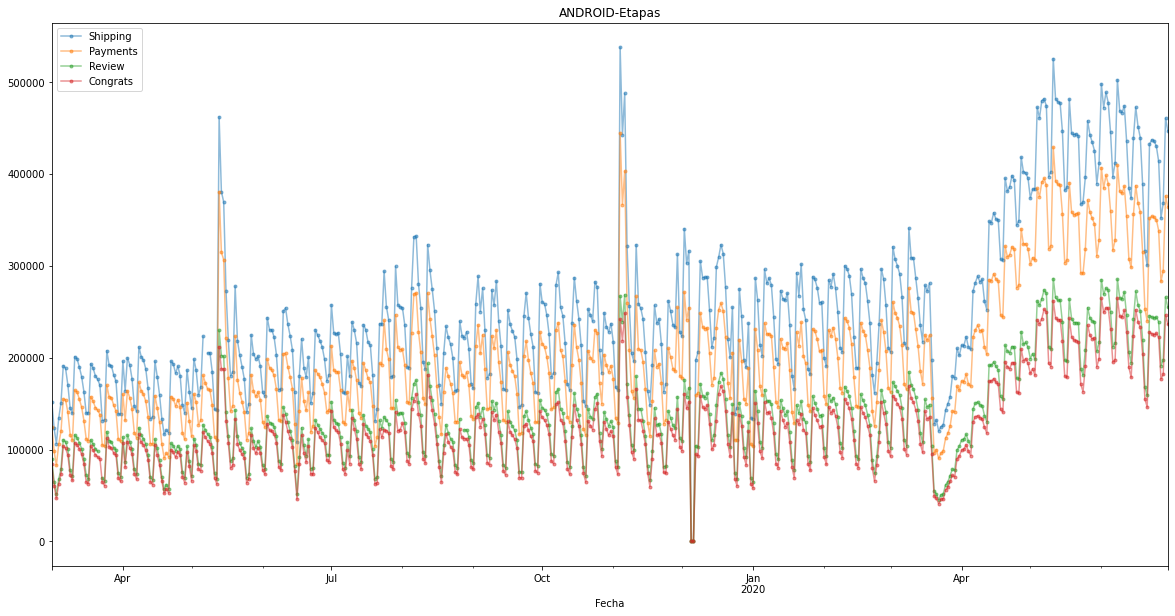

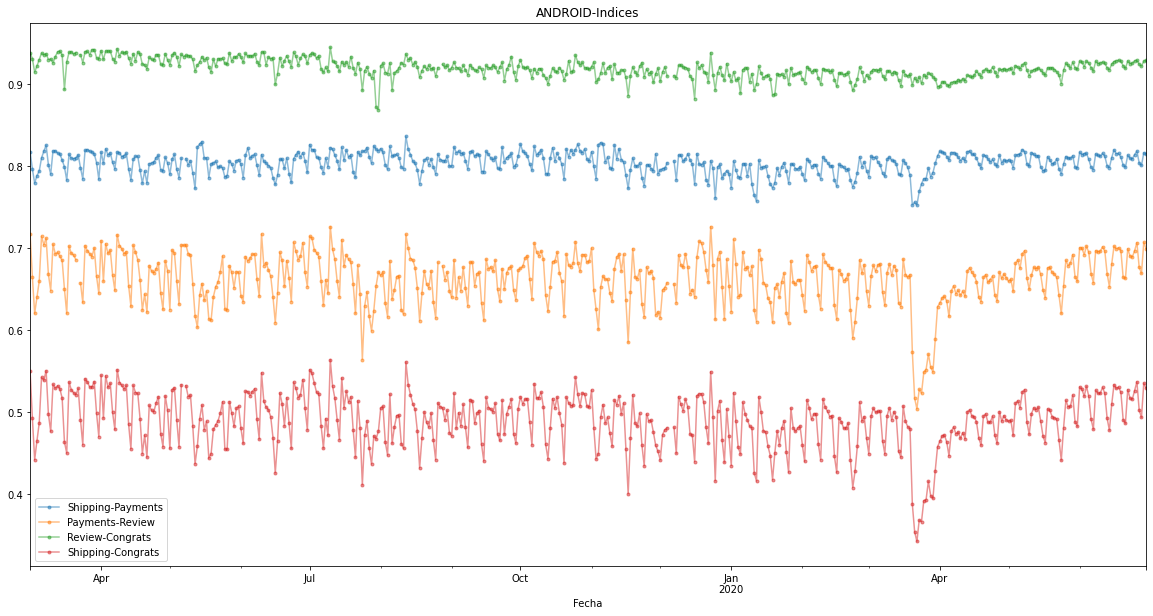

In [94]:
df_traffic_android[cols_etapas].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID-Etapas")
df_traffic_android[cols_indices].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID-Indices")

# Acá tienen que ir muchas conclusiones de que vemos

In [110]:
df_traffic_desktop[cols_indices].describe()

,Shipping-Payments,Payments-Review,Review-Congrats,Shipping-Congrats
count,486.00,486.00,486.00,486.00
mean,0.84,0.76,0.97,0.62
std,0.04,0.03,0.01,0.04
min,0.03,0.66,0.86,0.02
25%,0.84,0.74,0.97,0.60
50%,0.85,0.77,0.97,0.63
75%,0.85,0.78,0.98,0.65
max,0.88,0.81,1.00,0.68


In [ ]:
#analizamos los valores mínimos de cada índice que representan el 1% del total de los datos 
#el 1% de cada índice representa a 5 valores. Juntando los de cada índice podemos ver que al ser el total 12, cuando deberian ser 20 por lo que hay 8 casos que comparten fecha.
df_traffic_android_1ind= df_traffic_desktop[(df_traffic_desktop["Shipping-Payments"]<df_traffic_desktop["Shipping-Payments"].quantile(0.01))|(df_traffic_desktop["Payments-Review"]<df_traffic_desktop["Payments-Review"].quantile(0.01))|(df_traffic_desktop["Review-Congrats"]<df_traffic_desktop["Review-Congrats"].quantile(0.01))|(df_traffic_desktop["Shipping-Congrats"]<df_traffic_desktop["Shipping-Congrats"].quantile(0.01))]
df_traffic_android_1ind.shape

In [ ]:
df_traffic_android_1ind= df_traffic_android[(df_traffic_android["Shipping-Payments"]<df_traffic_android["Shipping-Payments"].quantile(0.01))|(df_traffic_android["Payments-Review"]<df_traffic_android["Payments-Review"].quantile(0.01))|(df_traffic_android["Review-Congrats"]<df_traffic_android["Review-Congrats"].quantile(0.01))|(df_traffic_android["Shipping-Congrats"]<df_traffic_android["Shipping-Congrats"].quantile(0.01))]
dates_min_ind_A=df_traffic_android_1ind.index

In [ ]:
dates_min_ind_D = df_traffic_android_1ind.index

In [ ]:
df_traffic_android_1ind

In [ ]:
#chequeamos la distribución de frecuencia según el día semanal
df_traffic_android_1ind.Weekday.value_counts()

In [ ]:
#chequeamos la distribuciòn de frecuencia según el mes y años... Podemos asumir que los 5 días correspondientes a marzo 2020 se deben al impacto social del anuncio de las restricciones iniciales del confinamiento por la pandemia
df_traffic_android_1ind.Months.value_counts()

In [ ]:
#compartidos entre SP- SC: 3 (3/5)
df_traffic_desktop_1indSP_SC= df_traffic_desktop[(df_traffic_desktop["Shipping-Payments"]<df_traffic_desktop["Shipping-Payments"].quantile(0.01))&(df_traffic_desktop["Shipping-Congrats"]<df_traffic_desktop["Shipping-Congrats"].quantile(0.01))]
df_traffic_desktop_1indSP_SC

In [ ]:
#compartidos entre PR- SC: 5 (5/5)
df_traffic_desktop_1indPRSC= df_traffic_desktop[(df_traffic_desktop["Payments-Review"]<df_traffic_desktop["Payments-Review"].quantile(0.01))&(df_traffic_desktop["Shipping-Congrats"]<df_traffic_desktop["Shipping-Congrats"].quantile(0.01))]
df_traffic_desktop_1indPRSC

In [ ]:
#df_traffic_desktop.loc[df_traffic_desktop["Shipping-Payment"]<df_traffic_desktop["Shipping-Payment"].quantile(0.01)]

In [ ]:
#df_traffic_desktop.loc[df_traffic_desktop["Payment-Review"]<df_traffic_desktop["Payment-Review"].quantile(0.01)]

In [ ]:
#df_traffic_desktop.loc[df_traffic_desktop["Review-Congrats"]<df_traffic_desktop["Review-Congrats"].quantile(0.01)]

In [ ]:
#df_traffic_desktop.loc[df_traffic_desktop["Shipping-Congrats"]<df_traffic_desktop["Shipping-Congrats"].quantile(0.01)]

In [ ]:
df_traffic_desktop_1DIF= df_traffic_desktop[df_traffic_desktop["Congrats"]>df_traffic_desktop["Shipping"]]
df_traffic_desktop_1DIF
#Verificamos que no haya ninguna secuencia con valores superiores respecto a su etapa posterior

In [ ]:
df_traffic_desktop[cols_indices].describe()

In [ ]:
df_traffic_desktop[(df_traffic_desktop["Review-Congrats"]>0.99)]

no hay tal dato sospechoso


In [ ]:
df_traffic_desktop_1et= df_traffic_desktop[(df_traffic_desktop["Shipping"]<df_traffic_desktop["Shipping"].quantile(0.01))|(df_traffic_desktop["Payments"]<df_traffic_desktop["Payments"].quantile(0.01))|(df_traffic_desktop["Review"]<df_traffic_desktop["Review"].quantile(0.01))|(df_traffic_desktop["Congrats"]<df_traffic_desktop["Congrats"].quantile(0.01))]
dates_min_et_D=df_traffic_desktop_1et.index

In [ ]:
df_traffic_android_1et= df_traffic_android[(df_traffic_android["Shipping"]<df_traffic_android["Shipping"].quantile(0.01))|(df_traffic_android["Payments"]<df_traffic_android["Payments"].quantile(0.01))|(df_traffic_android["Review"]<df_traffic_android["Review"].quantile(0.01))|(df_traffic_android["Congrats"]<df_traffic_android["Congrats"].quantile(0.01))]
dates_min_et_A=df_traffic_android_1et.index

**FECHAS DE ANALISIS**

In [ ]:
#consideramos las fechas obtenidas de los datos que representan el 1% mìnimo de los ìndices y de las etapas. 
dates_min_D = dates_min_ind_D | dates_min_et_D
dates_min_D

In [ ]:
dates_min_A = dates_min_ind_A | dates_min_et_A
dates_min_A

In [ ]:
#df_traffic_desktop.loc[df_traffic_desktop["Shipping"]<df_traffic_desktop["Shipping"].quantile(0.01)]

In [ ]:
#df_traffic_desktop.loc[df_traffic_desktop["Payments"]<df_traffic_desktop["Payments"].quantile(0.01)]

In [ ]:
#df_traffic_desktop.loc[df_traffic_desktop["Review"]<df_traffic_desktop["Review"].quantile(0.01)]

In [ ]:
#df_traffic_desktop.loc[df_traffic_desktop["Congrats"]<df_traffic_desktop["Congrats"].quantile(0.01)]

## Referencias adicionales

[pandas e interpolate ]( https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html)

[Manejo de valores perdidos]( https://pandas-docs.github.io/pandas-docs-travis/user_guide/missing_data.html )

https://towardsdatascience.com/a-practical-guide-on-missing-values-with-pandas-8fb3e0b46c24

https://towardsdatascience.com/handling-missing-values-the-exclusive-pythonic-guide-9aa883835655


In [ ]:
df_traffic_android = df_traffic_android.replace(['0', 0], np.nan)


In [ ]:
df_traffic_android_nan = df_traffic_android[(df_traffic_android["Review"].isna())|(df_traffic_android["Shipping"].isna())]
df_traffic_android_nan

In [ ]:
kinds = ('linear', 'index', 'pad', 'values', 'nearest', 'zero', 'slinear',
         'quadratic', 'cubic', 'barycentric', 'krogh', 'akima',
         'from_derivatives', 'pchip', 'spline', 'polynomial')
traffic_data_A_int = df_traffic_android.interpolate()

In [ ]:
tt=traffic_data_A_int[traffic_data_A_int['Months']=="December-2019"]
tt[tt['Weekday']=="Friday"]

In [ ]:
df_traffic_android['2019-03':'2019-08'][cols_etapas].plot( marker='.', alpha=0.5, linestyle='-',sharey="all",figsize=(20, 10)).set_title("ANDROID-Etapas")
df_traffic_android['2019-03':'2019-08'][cols_indices].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID-Indices")

In [ ]:
traffic_data_A_int['2019-12'][cols_etapas].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID INTERP-Etapas")
traffic_data_A_int['2019-12'][cols_indices].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10)).set_title("ANDROID INTERP-Indices")

In [ ]:
#traffic_data_A_intC = df_traffic_android.interpolate(method='cubic')
#traffic_data_A_intC[traffic_data_A_intC['Payments']==172472]

In [ ]:
#traffic_data_A_intP = df_traffic_android.interpolate(method='polynomial', order=3 )
#traffic_data_A_intP[traffic_data_A_intP['Payments']==172472]

Tanto la interpolación cúbica como la polinomial de 3er orden fueron descartadas dado que los valores imputados no eran lógicos. 

In [ ]:
#convertimos los ceros a nan
df_traffic = df_traffic.replace(['0', 0], np.nan)

In [ ]:
#interpolamos el data set completo de android y desktop
df_traffic_int=df_traffic.interpolate()

In [ ]:
#recalculamos las tasas de conversión entre las diferentes etapas de compra luego de haber interpolado
df_traffic_int["Shipping-Payments"] = df_traffic_int["Payments"] / df_traffic_int["Shipping"]
df_traffic_int["Payments-Review"] = df_traffic_int["Review"] / df_traffic_int["Payments"]
df_traffic_int["Review-Congrats"] = df_traffic_int["Congrats"] / df_traffic_int["Review"]
df_traffic_int["Shipping-Congrats"] = df_traffic_int["Congrats"] / df_traffic_int["Shipping"]

In [ ]:
cols_indices

In [ ]:
cols_indices_log=['Shipping-Payments(log)',
 'Payments-Review(log)',
 'Review-Congrats(log)',
 'Shipping-Congrats(log)']
cols_indices_log

In [ ]:
df_traffic[cols_indices_log] = np.log(df_traffic[cols_indices])

In [ ]:
df_traffic_int[cols_indices_log] = np.log(df_traffic_int[cols_indices])

In [ ]:
df_traffic_int.head()

In [ ]:
# volvemos a definir los dos datasets de interes con las nuevas columnas
df_traffic_int_desktop = df_traffic_int[df_traffic_int.Device==("Desktop")]
df_traffic_int_android = df_traffic_int[df_traffic_int.Device==("Android")]

In [ ]:
df_traffic[df_traffic_int["Device"]=="Android"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10), ylim=[-1,0]).set_title("ANDROID - indices log")
df_traffic_int[df_traffic_int["Device"]=="Android"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10),).set_title("ANDROID interpolada indices log")

In [ ]:
df_traffic[df_traffic_int["Device"]=="Desktop"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10), ylim=[-1,0]).set_title("DESKTOP - indices log")
df_traffic_int[df_traffic_int["Device"]=="Desktop"][cols_indices_log].plot( marker='.', alpha=0.5, linestyle='-',sharey="all", figsize=(20, 10),).set_title("DESKTOP interpolada indices log")

In [ ]:
df_traffic[cols_indices_log].describe()

In [ ]:
df_traffic_int[cols_indices_log].describe()